$$\frac{d}{dx}\left(m_{uu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{uv}\frac{dv}{dx}\right)=f_1\qquad x\in\,(0,2\,\pi)$$
$$\frac{d}{dx}\left(m_{vu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{vv}\frac{dv}{dx}\right)=f_2\qquad x\in\,(0,2\,\pi)$$

In [1]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
# plt.style.use('tableau-colorblind10')
# plt.style.use('default')
import mylib

# import seaborn as sns
# sns.color_palette("dark")
# sns.set_theme(style="whitegrid")

def u_sol(x, kwargs):
    return np.exp(np.sin(x))

def du_soldx(x, kwargs):
    return np.cos(x)*np.exp(np.sin(x))

def d2u_soldx2(x, kwargs):
    return -np.sin(x)*np.exp(np.sin(x)) + np.square(np.cos(x))*np.exp(np.sin(x))


def v_sol(x, kwargs):
    return - np.square(x) + x - 1.0 

def dv_soldx(x, kwargs):
    return - 2.0*x + 1.0

def d2v_soldx2(x, kwargs):
    return - 2.0 + 0.0*x


def fmuu(x, kwargs):
    return kwargs['A'] + kwargs['B']*np.sin(kwargs['C']*x)

def dfmuudx(x, kwargs):
    return kwargs['B']*kwargs['C']*np.cos(kwargs['C']*x)


def fmuv(x, kwargs):
    return kwargs['D'] + kwargs['E']*x

def dfmuvdx(x, kwargs):
    return kwargs['E'] + 0.0*x


def fmvu(x, kwargs):
    return -fmuv(x, kwargs)

def dfmvudx(x, kwargs):
    return -dfmuvdx(x, kwargs)


def fmvv(x, kwargs):
    return kwargs['F'] + kwargs['G']*np.sin(kwargs['H']*x)

def dfmvvdx(x, kwargs):
    return kwargs['G']*kwargs['H']*np.cos(kwargs['H']*x)


def f_1(x, kwargs):
    return dfmuudx(x, kwargs)*du_soldx(x, kwargs) + fmuu(x, kwargs)*d2u_soldx2(x, kwargs) + dfmuvdx(x, kwargs)*dv_soldx(x, kwargs) + fmuv(x, kwargs)*d2v_soldx2(x, kwargs)

def f_2(x, kwargs):
    return dfmvudx(x, kwargs)*du_soldx(x, kwargs) + fmvu(x, kwargs)*d2u_soldx2(x, kwargs) + dfmvvdx(x, kwargs)*dv_soldx(x, kwargs) + fmvv(x, kwargs)*d2v_soldx2(x, kwargs)

cond(Z) = 370848.75485370285
monolithic error = 4.7004457108485364e-11


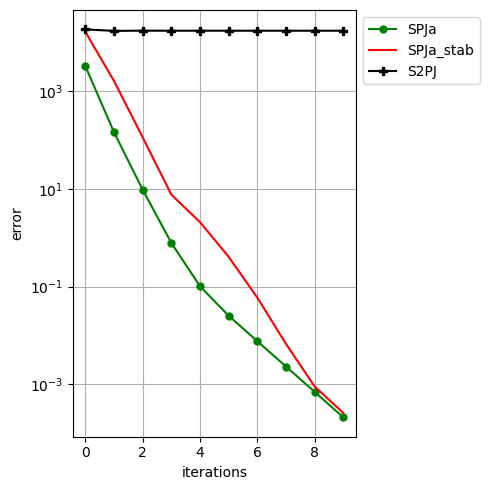

In [2]:
L = np.pi
N = 256
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)
nit_max = 10
toll = 1e-6

kwargs = {
    # muu coefficients
    'A': 1, #const
    'B': 0.5, #amplitude
    'C': 4.0, #frequency
    
    # muv=mvu coefficients
    'D': 1e-1, #const
    'E': 0, #slope
    
    # mvv coefficients
    'F': 1e-1, #const
    'G': 0.5e-1, #amplitude
    'H': 2  #frequency
    }

leftBC_u = {
    'type': 'dirichlet', #'type':'neumann',
    'value': u_sol(0.0, kwargs)}

rightBC_u = {
    'type': 'dirichlet', #'type':'neumann',
    'value': u_sol(L, kwargs)}

leftBC_v = {
    'type': 'dirichlet', #'type':'neumann',
    'value': v_sol(0.0, kwargs)}

rightBC_v = {
    'type': 'dirichlet', #'type':'neumann',
    'value': v_sol(L, kwargs)}

A, fuuBC = mylib.fvm_laplacian_1D(fmuu, leftBC_u, rightBC_u, N, L, kwargs)
B, fuvBC = mylib.fvm_laplacian_1D(fmuv, leftBC_v, rightBC_v, N, L, kwargs)
C, fvuBC = mylib.fvm_laplacian_1D(fmvu, leftBC_u, rightBC_u, N, L, kwargs)
D, fvvBC = mylib.fvm_laplacian_1D(fmvv, leftBC_v, rightBC_v, N, L, kwargs)

f1 = f_1(xc, kwargs) + fuuBC + fuvBC
f2 = f_2(xc, kwargs) + fvuBC + fvvBC

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A.toarray()
Z[:N,N:] = B.toarray()
Z[N:,:N] = C.toarray()
Z[N:,N:] = D.toarray()
Z = sparse.csc_matrix(Z)
f = np.concatenate((f1, f2))
sol = sparse.linalg.spsolve(Z, f)
u = sol[:N]
v = sol[N:]
u_rec = mylib.fvm_reconstruct_1D(u)
v_rec = mylib.fvm_reconstruct_1D(v)

u_BJ,   v_BJ,   res_BJ,   nit_BJ   = mylib.method_BlockJacobi(          A, B, C, D, f1, f2, nit_max, toll)
u_BGS,  v_BGS,  res_BGS,  nit_BGS  = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit_max, toll)

u_SPJa, v_SPJa, res_SPJa, nit_SPJa = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='alternate')
u_SPJu, v_SPJu, res_SPJu, nit_SPJu = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
u_SPJv, v_SPJv, res_SPJv, nit_SPJv = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')

u_S2PJ, v_S2PJ, res_S2PJ, nit_S2PJ = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll)

u_La, v_La, res_La, nit_La = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="both",   L=-0.1)
u_Lu, v_Lu, res_Lu, nit_Lu = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="L_on_u", L=-0.1)
u_Lv, v_Lv, res_Lv, nit_Lv = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="L_on_v", L=-0.1)

u_SPJa_stab, v_SPJa_stab, res_SPJa_stab, nitfinal_SPJa_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='alternate')
u_SPJu_stab, v_SPJu_stab, res_SPJu_stab, nitfinal_SPJu_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
u_SPJv_stab, v_SPJv_stab, res_SPJv_stab, nitfinal_SPJv_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')


Z = Z.toarray()
A = A.toarray()
B = B.toarray()
C = C.toarray()
D = D.toarray()

print(f"cond(Z) = {np.linalg.cond(Z)}")
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

#####################################################################################################

plt.figure(dpi=100, figsize=(5,5))
nn = 5
# plt.semilogy(res_BJ, 'b'  , label=f"BJ")
# plt.semilogy(res_BGS, 'k-', label=f"BGS")
plt.semilogy(res_SPJa, 'g.-', label=f"SPJa", markersize=10)
plt.semilogy(res_SPJa_stab, 'r-', label=f"SPJa_stab")
# plt.semilogy(res_SPJu, 'r.-', label=f"SPJu    slope={np.round(-mylib.slope(res_SPJu[:nn]), 3)}", markersize=10)
# plt.semilogy(res_SPJv, 'y.-', label=f"SPJv    slope={np.round(-mylib.slope(res_SPJv[:nn]), 3)}", markersize=10)
plt.semilogy(res_S2PJ, 'kP-', label=f"S2PJ")
# plt.semilogy(res_La,   'g*-', label=f"La      slope={np.round(-mylib.slope(res_La[:nn]), 3)}")
# plt.semilogy(res_Lu,   'r*-', label=f"Lu      slope={np.round(-mylib.slope(res_Lu[:nn]), 3)}")
# plt.semilogy(res_Lv,   'y*-', label=f"Lv      slope={np.round(-mylib.slope(res_Lv[:nn]), 3)}")
plt.legend(bbox_to_anchor=(1, 1.0))
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
# plt.savefig('figures/error2.pdf')


# fig, ax = plt.subplots(1, 2, figsize=(18,5), dpi=100)
# markersize = 20
# linewidth = 0.8
# ax[0].set_xlabel(r'$x$')
# ax[0].set_ylabel(r'$u,f_u$')
# ax[0].plot(x, 0*x, '|', color='k', markersize=6.0)
# ax[0].plot(xc, 0*xc, '.', color='k', markersize=2.0)
# ax[0].plot(x, mylib.fvm_reconstruct_1D(u), 'sk' , label=r'$u_{rec,monolithic}$', linewidth=linewidth)
# ax[0].plot(x, mylib.fvm_reconstruct_1D(u_BGS),  '.k' , label=r'$u_{rec,BGS}$',   linewidth=linewidth)
# ax[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJa), '.r' , label=r'$u_{rec,SPJa}$',  linewidth=linewidth)
# ax[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJu), '.y' , label=r'$u_{rec,SPJu}$',  linewidth=linewidth)
# ax[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJv), '.b' , label=r'$u_{rec,SPJv}$',  linewidth=linewidth)
# ax[0].plot(x, mylib.fvm_reconstruct_1D(u_S2PJ), '.g' , label=r'$u_{rec,S2PJ}$',  linewidth=linewidth)
# # ax[0].plot(xc, u, '_y', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=markersize)
# ax[0].plot(xfine, u_sol(xfine, kwargs), '-b', label=r'$u(x)$')
# #ax[0].plot(xfine, m_u(xfine, kwargs), '--g', label=r'$m_u(x)$')
# #ax[0].plot(xfine, f_u(xfine, kwargs), '--c', label=r'$f_u(x)$')
# ax[0].legend()
# ax[0].grid()

# ax[1].set_xlabel(r'$x$')
# ax[1].set_ylabel(r'$v,f_v$')
# ax[1].plot(x,  0*x, '|', color='k', markersize=6.0)
# ax[1].plot(xc, 0*xc, '.', color='k', markersize=2.0)
# ax[1].plot(x, mylib.fvm_reconstruct_1D(v), 'sk' , label=r'$v_{rec,monolithic}$', linewidth=linewidth)
# ax[1].plot(x, mylib.fvm_reconstruct_1D(v_BGS), '.y' , label=r'$u_{rec,BGS}$',    linewidth=linewidth)
# ax[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJa), '.k' , label=r'$v_{rec,SPJa}$',  linewidth=linewidth)
# ax[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJu), '.r' , label=r'$v_{rec,SPJu}$',  linewidth=linewidth)
# ax[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJv), '.b' , label=r'$v_{rec,SPJv}$',  linewidth=linewidth)
# ax[1].plot(x, mylib.fvm_reconstruct_1D(v_S2PJ), '.g' , label=r'$u_{rec,S2PJ}$',  linewidth=linewidth)
# # ax[1].plot(xc, v, '_y', label=r'$\frac{1}{|cell|}\int v\,dx$', markersize=markersize)
# ax[1].plot(xfine, v_sol(xfine, kwargs), '-b', label=r'$v(x)$')
# #ax[1].plot(xfine, m_v(xfine, kwargs), '--g', label=r'$m_v(x)$')
# #ax[1].plot(xfine, f_v(xfine, kwargs), '--c', label=r'$f_v(x)$')
# ax[1].legend()
# ax[1].grid()

# #ax[0].plot(x, mylib.fvm_reconstruct_1D(fTOT), '-g' , label='furec', linewidth=linewidth)
# #ax[0].plot(xc, ff, '_g', label='ff', markersize=markersize)
# #ax[0].set_ylim(bottom=-4, top=4)
# #ax[1].set_ylim(bottom=-4, top=4)
# #ax[0].set_xlim([-0.001,0.1])
plt.tight_layout()
plt.show()


In [ ]:
L = np.pi
N = 128
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)
omega = 1.0
nit_max = 100
toll = 1e-6

err = {
    "BJ":  {"nit":[], "u_errl2":[], "v_errl2":[]},
    "BGS": {"nit":[], "u_errl2":[], "v_errl2":[]},
    "BSOR":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJa":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJu":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJv":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "La":  {"nit":[], "u_errl2":[], "v_errl2":[]},
    "Lu":  {"nit":[], "u_errl2":[], "v_errl2":[]},
    "Lv":  {"nit":[], "u_errl2":[], "v_errl2":[]},
    "S2PJ":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "mono":{"u_errl2":[], "v_errl2":[]}
    }

# fig1, axs1 = plt.subplots(2, 1, figsize=(8,4), dpi=100, sharex=True)
fig1, axs1 = plt.subplots(1, 1, figsize=(5,3), dpi=100)
fig2, axs2 = plt.subplots(1, 1, figsize=(5,5), dpi=100)
fig3, axs3 = plt.subplots(1, 1, figsize=(5,5), dpi=100)
axs1.xaxis.set_major_formatter(plt.FuncFormatter(mylib.format_func))
axs1.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
markersize = 8
linewidth = 2
markevery = 1


beta = np.logspace(-2, 0, 10)
# beta = [0.001]
for val in beta:
    kwargs = {
    # muu coefficients
    'A': 1, #const
    'B': 0.5, #amplitude
    'C': 4.0, #frequency
    
    # muv=mvu coefficients
    'D': val, #const
    'E': 0, #slope
    
    # mvv coefficients
    'F': 1e-2/val, #const
    'G': 0.5e-2/val, #amplitude
    'H': 2  #frequency
    }

    leftBC_u = {
        'type': 'dirichlet', 
        'value': u_sol(0.0, kwargs)}

    rightBC_u = {
        'type': 'dirichlet', 
        'value': u_sol(L, kwargs)}

    leftBC_v = {
        'type': 'dirichlet', 
        'value': v_sol(0.0, kwargs)}

    rightBC_v = {
        'type': 'dirichlet', 
        'value': v_sol(L, kwargs)}

    A, fuuBC = mylib.fvm_laplacian_1D(fmuu, leftBC_u, rightBC_u, N, L, kwargs)
    B, fuvBC = mylib.fvm_laplacian_1D(fmuv, leftBC_v, rightBC_v, N, L, kwargs)
    C, fvuBC = mylib.fvm_laplacian_1D(fmvu, leftBC_u, rightBC_u, N, L, kwargs)
    D, fvvBC = mylib.fvm_laplacian_1D(fmvv, leftBC_v, rightBC_v, N, L, kwargs)

    f1 = f_1(xc, kwargs) + fuuBC + fuvBC
    f2 = f_2(xc, kwargs) + fvuBC + fvvBC

    Z = np.zeros((2*N,2*N))
    Z[:N,:N] = A.toarray()
    Z[:N,N:] = B.toarray()
    Z[N:,:N] = C.toarray()
    Z[N:,N:] = D.toarray()

    Z = sparse.csc_matrix(Z)
    f = np.concatenate((f1,f2))
    sol = sparse.linalg.spsolve(Z, f)
    u = sol[:N]
    v = sol[N:]
    u_rec = mylib.fvm_reconstruct_1D(u)
    v_rec = mylib.fvm_reconstruct_1D(v)

    u_BJ,   v_BJ,   res_BJ,   nitfinal_BJ   = mylib.method_BlockJacobi(          A, B, C, D, f1, f2, nit_max, toll)
    u_BGS,  v_BGS,  res_BGS,  nitfinal_BGS  = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit_max, toll)
    u_SPJa, v_SPJa, res_SPJa, nitfinal_SPJa = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='alternate')
    u_SPJu, v_SPJu, res_SPJu, nitfinal_SPJu = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
    u_SPJv, v_SPJv, res_SPJv, nitfinal_SPJv = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
    u_S2PJ, v_S2PJ, res_S2PJ, nitfinal_S2PJ = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll)
    u_La, v_La, res_La, nitfinal_La = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="both",   L=-0.5)
    u_Lu, v_Lu, res_Lu, nitfinal_Lu = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="L_on_u", L=-0.5)
    u_Lv, v_Lv, res_Lv, nitfinal_Lv = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="L_on_v", L=-0.5)
    
    err['mono']['u_errl2'].append((np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u))/np.linalg.norm(u_sol(x, kwargs))))
    err['mono']['v_errl2'].append((np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v))/np.linalg.norm(v_sol(x, kwargs))))

######################################

    Z = Z.toarray()
    A = A.toarray()
    B = B.toarray()
    C = C.toarray()
    D = D.toarray()

    err['BJ']['nit'].append(nitfinal_BJ)
    err['BJ']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BJ)))
    err['BJ']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BJ)))
    err['BGS']['nit'].append(nitfinal_BGS)
    err['BGS']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BGS)))
    err['BGS']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BGS)))
    err['SPJa']['nit'].append(nitfinal_SPJa)
    err['SPJa']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJa)))
    err['SPJa']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJa)))
    err['SPJu']['nit'].append(nitfinal_SPJu)
    err['SPJu']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJu)))
    err['SPJu']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJu)))
    err['SPJv']['nit'].append(nitfinal_SPJv)
    err['SPJv']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJv)))
    err['SPJv']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJv)))
    err['S2PJ']['nit'].append(nitfinal_S2PJ)
    err['S2PJ']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_S2PJ)))
    err['S2PJ']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_S2PJ)))
    err['La']['nit'].append(nitfinal_La)
    err['La']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_La)))
    err['La']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_La)))
    err['Lu']['nit'].append(nitfinal_Lu)
    err['Lu']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_Lu)))
    err['Lu']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_Lu)))
    err['Lv']['nit'].append(nitfinal_Lv)
    err['Lv']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_Lv)))
    err['Lv']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_Lv)))

    ##################################################################

    # axs1[0].plot(x, 0*x, '|', color='k', markersize=6.0)
    # axs1[0].plot(xc, 0*xc, '.', color='k', markersize=2.0)
    # axs1[0].plot(x, mylib.fvm_reconstruct_1D(u), 'sk' , label=r'$u_{rec,monolithic}$', linewidth=linewidth, markersize=markersize)
    # axs1[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJa), 'xr' , label=r'$u_{rec,SPJa}$', linewidth=linewidth, markersize=markersize)
    # axs1[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJu), 'xb' , label=r'$u_{rec,SPJu}$', linewidth=linewidth, markersize=markersize)
    # axs1[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJv), 'xy' , label=r'$u_{rec,SPJv}$', linewidth=linewidth, markersize=markersize)
    # axs1[0].plot(x, mylib.fvm_reconstruct_1D(u_S2PJ), '+g' , label=r'$u_{rec,S2PJ}$', linewidth=linewidth)
    # axs1[0].plot(xc, u, '_y', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=markersize)
    # axs1[0].plot(xfine, u_sol(xfine, kwargs), '-b', label=r'$u(x)$')
    # axs1.plot(xfine, u_sol(xfine, kwargs), '-k', label=r'$u(x)$')
    # axs1.plot(xfine, v_sol(xfine, kwargs), '--k', label=r'$u(x)$')
    # axs1[0].plot(xfine, m_u(xfine, kwargs), '--g', label=r'$m_u(x)$')
    # axs1[0].plot(xfine, f_1(xfine, kwargs), '--c', label=r'$f_u(x)$')

    # axs1[1].plot(x, 0*x, '|', color='k', markersize=6.0)
    # axs1[1].plot(xc, 0*xc, '.', color='k', markersize=2.0)
    # axs1[1].plot(x, mylib.fvm_reconstruct_1D(v), 'sk' , label=r'$v_{rec,monolithic}$', linewidth=linewidth, markersize=markersize)
    # axs1[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJa), 'xr' , label=r'$v_{rec,SPJa}$', linewidth=linewidth, markersize=markersize)
    # axs1[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJu), 'xb' , label=r'$v_{rec,SPJu}$', linewidth=linewidth, markersize=markersize)
    # axs1[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJv), 'xy' , label=r'$v_{rec,SPJv}$', linewidth=linewidth, markersize=markersize)
    # axs1[1].plot(x, mylib.fvm_reconstruct_1D(v_S2PJ), '+g' , label=r'$v_{rec,S2PJ}$', linewidth=linewidth)
    # axs1[1].plot(xc, v, '_y', label=r'$\frac{1}{|cell|}\int v\,dx$', markersize=markersize)
    # axs1[1].plot(xfine, v_sol(xfine, kwargs), '-b', label=r'$v(x)$')
    # axs1[1].plot(xfine, m_v(xfine, kwargs), '--g', label=r'$m_v(x)$')
    # axs1[1].plot(xfine, f_2(xfine, kwargs), '--c', label=r'$f_v(x)$')

axs1.plot(xfine, u_sol(xfine, kwargs), '-k', label=r'$u(x)$')
axs1.plot(xfine, v_sol(xfine, kwargs), '--k', label=r'$u(x)$')
axs1.grid()
axs1.legend()
# axs1[0].set_ylabel(r'$u$')
# axs1[0].grid()
# axs1[1].set_xlabel(r'$x$')
# axs1[1].set_ylabel(r'$v$')
# axs1[1].grid()
# axs1[0].legend()
# axs1[1].legend()
fig1.savefig('./figures/ql_1D_beta_results.pdf')


axs2.loglog(beta, err['BJ']['nit'],  'k', linestyle='solid',  label=f"BJ",   linewidth=linewidth, markersize=markersize)
axs2.loglog(beta, err['BGS']['nit'], 'k', linestyle='dashed', label=f"BGS",  linewidth=linewidth, markersize=markersize)
axs2.loglog(beta, err['SPJa']['nit'],'d', linestyle='',       label=f"SPJa", linewidth=linewidth, markersize=markersize)
# axs2.loglog(beta, err['SPJu']['nit'],'x', linestyle='',       label=f"SPJu", linewidth=linewidth, markersize=markersize)
# axs2.loglog(beta, err['SPJv']['nit'],'o', linestyle='',       label=f"SPJv", linewidth=linewidth, markersize=markersize)
# axs2.loglog(beta, err['La']['nit'],   'rP-', label=r'$La$')
# axs2.loglog(beta, err['Lu']['nit'],   'bP-', label=r'$Lu$')
# axs2.loglog(beta, err['Lv']['nit'],   'gP-', label=r'$Lv$')
axs2.loglog(beta, err['S2PJ']['nit'], 'og', label=r'$S2PJ$', linewidth=linewidth, markersize=markersize)
axs2.set_xlabel(r"$\beta$")
axs2.set_ylabel(r"$\#~iterations$")
axs2.grid(which='both')
axs2.legend()
fig2.savefig('./figures/ql_1D_beta_it_100-1e-6.pdf')


axs3.loglog(beta, err['mono']['u_errl2'], 's-', label=r'$Monolithic$')
axs3.loglog(beta, err['BJ']['u_errl2'],   'k.-', label=r'$BJ$')
axs3.loglog(beta, err['BGS']['u_errl2'],  'r.-', label=r'$BGS$')
axs3.loglog(beta, err['SPJa']['u_errl2'], 'r>-', label=r'$SPJa$')
# axs3.loglog(beta, err['SPJu']['u_errl2'], 'b>-', label=r'$SPJu$')
# axs3.loglog(beta, err['SPJv']['u_errl2'], 'g>-', label=r'$SPJv$')
# axs3.loglog(beta, err['La']['u_errl2'],   'rP-', label=r'$La$')
# axs3.loglog(beta, err['Lu']['u_errl2'],   'bP-', label=r'$Lu$')
# axs3.loglog(beta, err['Lv']['u_errl2'],   'gP-', label=r'$Lv$')
axs3.loglog(beta, err['S2PJ']['u_errl2'], 'k3-', label=r'$S2PJ$', markersize=10)
axs3.set_xlabel(r"$\beta$")
axs3.set_ylabel(r"$||u(x_f)-u_h(x_f)||_{\mathbb{R}^N}$")#
axs3.grid()
axs3.legend()
# fig3.savefig('./figures/dualporosity_varbeta_error-fixed-iterations-50.pdf')

plt.show()